In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
%matplotlib inline
from datetime import datetime
import baostock as bs
import warnings  #屏蔽报红
warnings.filterwarnings("ignore")

In [2]:
def get_data(code):
    end = datetime.now()
    start = datetime(end.year - 3, end.month, end.day).strftime('%Y-%m-%d')
    end = end.strftime('%Y-%m-%d')
    # 登陆系统
    lg = bs.login()
    # 获取沪深A股历史K线数据
    rs_result = bs.query_history_k_data_plus(
            code,
            fields="date,open,high,low,close,volume",
            start_date=start, 
            end_date=end, 
            frequency="d", 
            adjustflag="3")
    df_result = rs_result.get_data()
    # 登出系统
    bs.logout()
    df_result['date'] = df_result['date'].map(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    _res = df_result.set_index('date')
    res = _res.applymap(lambda x: float(x))
    return res

In [3]:
liquor_list = ['sh.600519', 'sz.000858', 
               'sz.002304', 'sh.600809']
# 贵州茅台，五粮液， 洋河股份，山西汾酒
company_name = ['maotai','wuliangye','yanghe','fenjiu']
for name, code in zip(company_name ,liquor_list):
    exec(f"{name}=get_data(code)")

login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!


In [4]:
# 需要批量赋值的变量名称
company_list = [maotai, wuliangye, yanghe, fenjiu]
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
# 将四支股票数据进行纵向合并
df = pd.concat(company_list, axis=0)
df.tail(10)

,open,high,low,close,volume,company_name
date,,,,,,
2023-03-31,275.00,278.53,272.00,272.40,4123178.0,fenjiu
2023-04-03,271.00,272.39,265.90,267.82,5680183.0,fenjiu
2023-04-04,267.77,268.88,263.77,267.36,6206688.0,fenjiu
2023-04-06,266.18,266.18,257.00,257.26,7004683.0,fenjiu
2023-04-07,255.03,257.00,250.30,252.39,8452528.0,fenjiu
2023-04-10,250.20,250.29,241.00,244.11,9829010.0,fenjiu
2023-04-11,245.90,252.00,245.08,245.56,8812822.0,fenjiu
2023-04-12,245.99,248.84,240.01,241.08,6701845.0,fenjiu
2023-04-13,241.00,250.00,239.09,246.67,7404078.0,fenjiu


In [5]:
# 获取股票报价
df = maotai.loc[:,['open','high','low','close','volume']]
df.head()

,open,high,low,close,volume
date,,,,,
2020-04-15,1192.00,1203.99,1187.10,1189.6,2933229.0
2020-04-16,1192.97,1197.10,1184.10,1197.1,2172774.0
2020-04-17,1210.00,1234.56,1205.01,1226.0,3824569.0
2020-04-20,1221.00,1231.50,1216.80,1227.3,2423864.0
2020-04-21,1221.02,1223.99,1193.00,1200.0,2922422.0


In [6]:
# 数据标准化
from sklearn.preprocessing import MinMaxScaler
df_scale = df
scaler = MinMaxScaler(feature_range=(0,1))
scale_data = scaler.fit_transform(df_scale)
# scale_data.shape[0]
# scale_data.shape[1]
df_scale.loc[:,'open'] = scale_data[:, 0]
df_scale.loc[:,'high'] = scale_data[:, 1]
df_scale.loc[:,'low'] = scale_data[:, 2]
df_scale.loc[:,'close'] = scale_data[:, 3]
df_scale.loc[:,'volume'] = scale_data[:, 4]
df_scale.head()

,open,high,low,close,volume
date,,,,,
2020-04-15,0.000000,0.004816,0.002306,0.000000,0.138797
2020-04-16,0.000695,0.000000,0.000000,0.005314,0.075069
2020-04-17,0.012894,0.026182,0.016073,0.025790,0.213493
2020-04-20,0.020774,0.024043,0.025136,0.026711,0.096110
2020-04-21,0.020788,0.018794,0.006841,0.007369,0.137891


In [7]:
#数据切分
Y = df_scale.filter(['close'])
Y = Y.values
X = df_scale.filter(['open','high','low','volume'])
X = X.values
training_data_len = int(np.ceil( len(df) * .95 ))
X_train = X[0:int(training_data_len), :]
Y_train = Y[0:int(training_data_len), :]
X_test = X[int(training_data_len):, :]
Y_test = Y[int(training_data_len):, :]
X_train

array([[0.        , 0.00481556, 0.0023061 , 0.13879659],
       [0.00069485, 0.        , 0.        , 0.0750685 ],
       [0.01289417, 0.02618152, 0.01607349, 0.21349317],
       ...,
       [0.45057952, 0.4764534 , 0.48666308, 0.1416157 ],
       [0.48854568, 0.47309859, 0.51264509, 0.05011863],
       [0.47494233, 0.4660395 , 0.49788608, 0.07625364]])

In [8]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor(max_depth=4, n_estimators=10, min_samples_leaf=5, random_state=1)
model1.fit(X_train, Y_train)
Y_pred1 = model1.predict(X_test)

In [9]:
from sklearn import metrics
# MSE
print("MSE: %.4f" %(metrics.mean_squared_error(Y_test,Y_pred1)))     
# RMSE
print("RMSE: %.4f" %(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred1))))       
# MAE
print("MAE: %.4f" %(metrics.mean_absolute_error(Y_test,Y_pred1))) 
# R2_Score
print("R2_Score: %.4f" % (metrics.r2_score(Y_test,Y_pred1)))

MSE: 0.0001
RMSE: 0.0111
MAE: 0.0083
R2_Score: 0.7747


In [10]:
close_data = maotai.loc[:,['close']]
test_data = np.append(X_test[:, :3], Y_pred1.reshape(-1, 1), axis=1)
test_data = np.append(test_data, X_test[:, 3].reshape(-1, 1), axis=1)
test_data = scaler.inverse_transform(test_data)
test_data

array([[1.84000000e+03, 1.84880000e+03, 1.80525000e+03, 1.83396260e+03,
        2.18809700e+06],
       [1.81011000e+03, 1.81019000e+03, 1.78218000e+03, 1.78424300e+03,
        2.46346100e+06],
       [1.77850000e+03, 1.81500000e+03, 1.77502000e+03, 1.78424300e+03,
        2.20648900e+06],
       [1.81900000e+03, 1.82201000e+03, 1.78330000e+03, 1.78424300e+03,
        2.39518100e+06],
       [1.81300000e+03, 1.84800000e+03, 1.80323000e+03, 1.83396260e+03,
        2.44581000e+06],
       [1.82900000e+03, 1.83899000e+03, 1.82110000e+03, 1.82203266e+03,
        1.31441900e+06],
       [1.83977000e+03, 1.84161000e+03, 1.80248000e+03, 1.82934580e+03,
        1.61980600e+06],
       [1.81818000e+03, 1.81850000e+03, 1.79677000e+03, 1.79594073e+03,
        2.06458600e+06],
       [1.80598000e+03, 1.81660000e+03, 1.78800000e+03, 1.78968010e+03,
        2.27853900e+06],
       [1.78002000e+03, 1.78594000e+03, 1.76112000e+03, 1.77376722e+03,
        2.27637000e+06],
       [1.76800000e+03, 1.7850

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

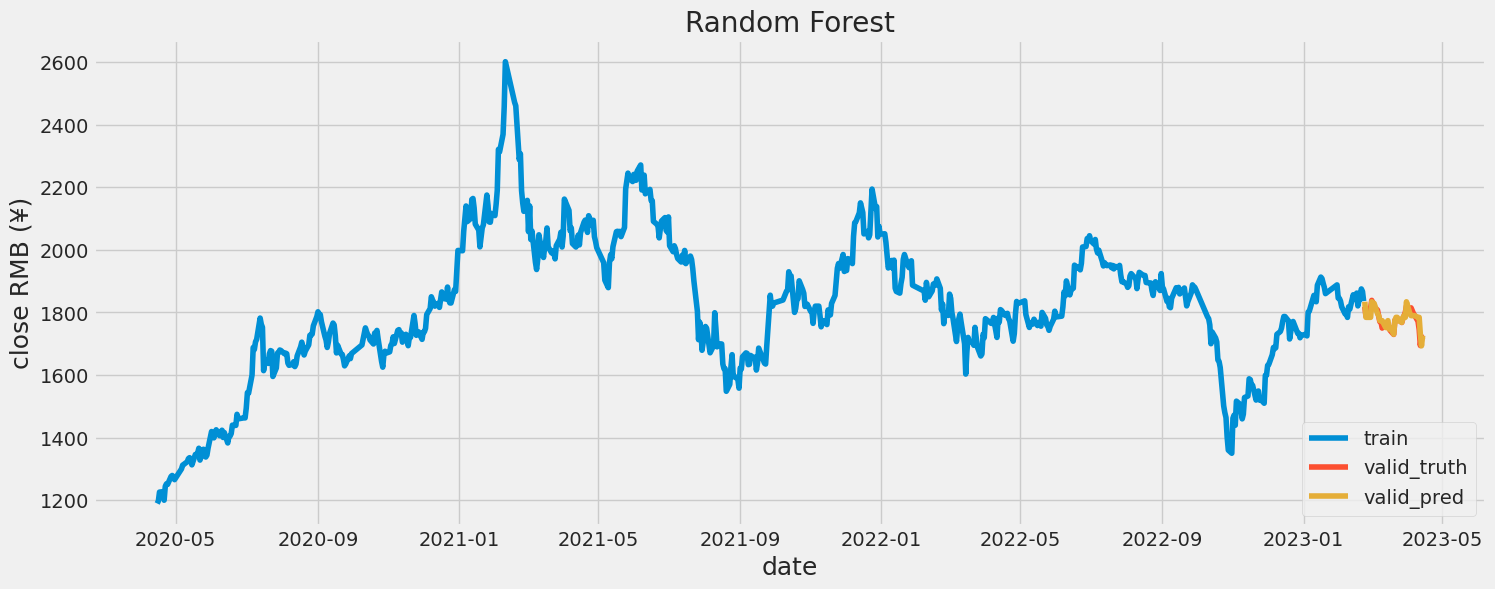

In [11]:
train = close_data[:int(training_data_len)]
valid = close_data[int(training_data_len):]
valid['Predictions'] = test_data[:, 3]
plt.figure(figsize=(16,6))
plt.title('Random Forest')
plt.xlabel('date', fontsize=18)
plt.ylabel('close RMB (¥)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['train', 'valid_truth', 'valid_pred'], loc='lower right')
plt.show()

In [12]:
from sklearn import metrics
# MSE
print("MSE: %.4f" %(metrics.mean_squared_error(valid['close'],valid['Predictions'])))     
# RMSE
print("RMSE: %.4f" %(np.sqrt(metrics.mean_squared_error(valid['close'],valid['Predictions']))))       
# MAE
print("MAE: %.4f" %(metrics.mean_absolute_error(valid['close'],valid['Predictions']))) 
# R2_Score
print("R2_Score: %.4f" % (metrics.r2_score(valid['close'],valid['Predictions'])))

MSE: 246.8150
RMSE: 15.7103
MAE: 11.6770
R2_Score: 0.7747


In [13]:
#RF prediction
valid

,close,Predictions
date,,
2023-02-23,1818.00,1833.962600
2023-02-24,1788.00,1784.243005
2023-02-27,1810.41,1784.243005
2023-02-28,1813.74,1784.243005
2023-03-01,1838.53,1833.962600
2023-03-02,1828.00,1822.032665
2023-03-03,1818.04,1829.345804
2023-03-06,1807.14,1795.940731
2023-03-07,1788.30,1789.680101


In [14]:
import xgboost as xgb
from xgboost import plot_importance
evalset = [(X_train, Y_train), (X_test,Y_test)]
model2 = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160)
model2.fit(X_train, Y_train, eval_metric='logloss', eval_set=evalset)

[0]	validation_0-logloss:0.68320	validation_1-logloss:0.69033
[1]	validation_0-logloss:0.67503	validation_1-logloss:0.68810
[2]	validation_0-logloss:0.66829	validation_1-logloss:0.68630
[3]	validation_0-logloss:0.66269	validation_1-logloss:0.68487
[4]	validation_0-logloss:0.65803	validation_1-logloss:0.68369
[5]	validation_0-logloss:0.65415	validation_1-logloss:0.68268
[6]	validation_0-logloss:0.65090	validation_1-logloss:0.68192
[7]	validation_0-logloss:0.64818	validation_1-logloss:0.68128
[8]	validation_0-logloss:0.64590	validation_1-logloss:0.68075
[9]	validation_0-logloss:0.64398	validation_1-logloss:0.68033
[10]	validation_0-logloss:0.64237	validation_1-logloss:0.67998
[11]	validation_0-logloss:0.64101	validation_1-logloss:0.67968
[12]	validation_0-logloss:0.63986	validation_1-logloss:0.67943
[13]	validation_0-logloss:0.63890	validation_1-logloss:0.67923
[14]	validation_0-logloss:0.63808	validation_1-logloss:0.67907
[15]	validation_0-logloss:0.63739	validation_1-logloss:0.67893
[1

[130]	validation_0-logloss:0.63328	validation_1-logloss:0.67831
[131]	validation_0-logloss:0.63328	validation_1-logloss:0.67831
[132]	validation_0-logloss:0.63328	validation_1-logloss:0.67831
[133]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[134]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[135]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[136]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[137]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[138]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[139]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[140]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[141]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[142]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[143]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[144]	validation_0-logloss:0.63327	validation_1-logloss:0.67831
[145]	validation_0-logloss:0.63327	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=160, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [15]:
Y_pred2 = model2.predict(X_test)
# MSE
print("MSE: %.4f" %(metrics.mean_squared_error(Y_test,Y_pred2)))     
# RMSE
print("RMSE: %.4f" %(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred2))))       
# MAE
print("MAE: %.4f" %(metrics.mean_absolute_error(Y_test,Y_pred2))) 
# R2_Score
print("R2_Score: %.4f" % (metrics.r2_score(Y_test,Y_pred2)))

MSE: 0.0001
RMSE: 0.0074
MAE: 0.0060
R2_Score: 0.9010


In [16]:
close_data = maotai.loc[:,['close']]
test_data = np.append(X_test[:, :3], Y_pred2.reshape(-1, 1), axis=1)
test_data = np.append(test_data, X_test[:, 3].reshape(-1, 1), axis=1)
test_data = scaler.inverse_transform(test_data)
test_data

array([[1.84000000e+03, 1.84880000e+03, 1.80525000e+03, 1.83244951e+03,
        2.18809700e+06],
       [1.81011000e+03, 1.81019000e+03, 1.78218000e+03, 1.78612570e+03,
        2.46346100e+06],
       [1.77850000e+03, 1.81500000e+03, 1.77502000e+03, 1.79875095e+03,
        2.20648900e+06],
       [1.81900000e+03, 1.82201000e+03, 1.78330000e+03, 1.79026360e+03,
        2.39518100e+06],
       [1.81300000e+03, 1.84800000e+03, 1.80323000e+03, 1.83185895e+03,
        2.44581000e+06],
       [1.82900000e+03, 1.83899000e+03, 1.82110000e+03, 1.82485663e+03,
        1.31441900e+06],
       [1.83977000e+03, 1.84161000e+03, 1.80248000e+03, 1.81717181e+03,
        1.61980600e+06],
       [1.81818000e+03, 1.81850000e+03, 1.79677000e+03, 1.80498267e+03,
        2.06458600e+06],
       [1.80598000e+03, 1.81660000e+03, 1.78800000e+03, 1.79912413e+03,
        2.27853900e+06],
       [1.78002000e+03, 1.78594000e+03, 1.76112000e+03, 1.77109217e+03,
        2.27637000e+06],
       [1.76800000e+03, 1.7850

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

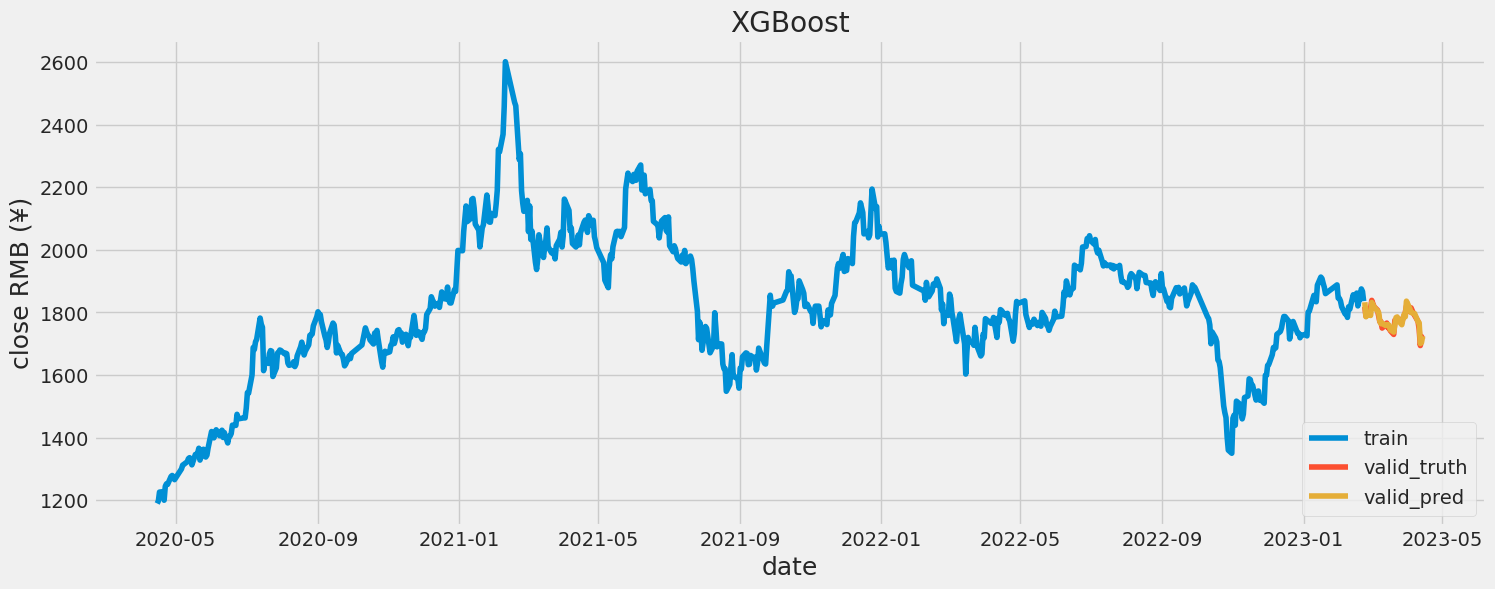

In [17]:
train = close_data[:int(training_data_len)]
valid = close_data[int(training_data_len):]
valid['Predictions'] = test_data[:, 3]
plt.figure(figsize=(16,6))
plt.title('XGBoost')
plt.xlabel('date', fontsize=18)
plt.ylabel('close RMB (¥)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['train', 'valid_truth', 'valid_pred'], loc='lower right')
plt.show()

In [18]:
from sklearn import metrics
# MSE
print("MSE: %.4f" %(metrics.mean_squared_error(valid['close'],valid['Predictions'])))     
# RMSE
print("RMSE: %.4f" %(np.sqrt(metrics.mean_squared_error(valid['close'],valid['Predictions']))))       
# MAE
print("MAE: %.4f" %(metrics.mean_absolute_error(valid['close'],valid['Predictions']))) 
# R2_Score
print("R2_Score: %.4f" % (metrics.r2_score(valid['close'],valid['Predictions'])))

MSE: 108.4691
RMSE: 10.4149
MAE: 8.5057
R2_Score: 0.9010


In [17]:
# XGBoost prediction
valid

,close,Predictions
date,,
2023-02-22,1836.00,1841.833429
2023-02-23,1818.00,1831.393526
2023-02-24,1788.00,1787.591325
2023-02-27,1810.41,1798.395388
2023-02-28,1813.74,1790.576728
2023-03-01,1838.53,1832.847090
2023-03-02,1828.00,1825.767133
2023-03-03,1818.04,1816.712857
2023-03-06,1807.14,1804.016380


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


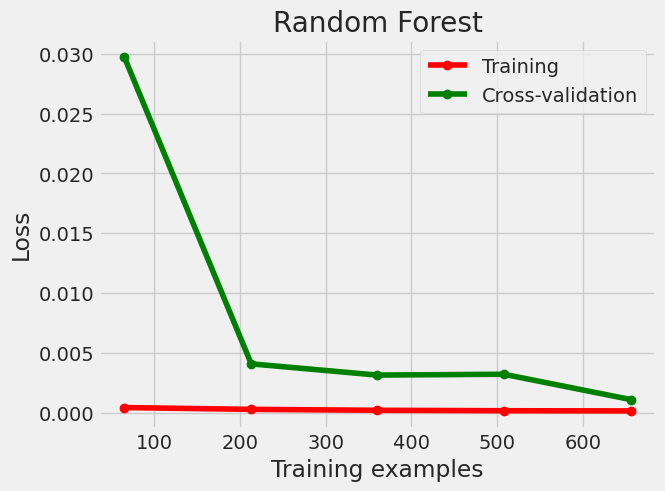

In [19]:
from sklearn.model_selection import learning_curve
train_sizes, train_loss, test_loss = learning_curve(
    model1, X, Y, cv=10, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(.1, 1.0, 5))
# loss值为负数，需要取反
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

# 设置样式与label
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
         label="Training")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
        label="Cross-validation")
plt.title('Random Forest')
plt.xlabel("Training examples")
plt.ylabel("Loss")
# 显示图例
plt.legend(loc="best")
plt.show()

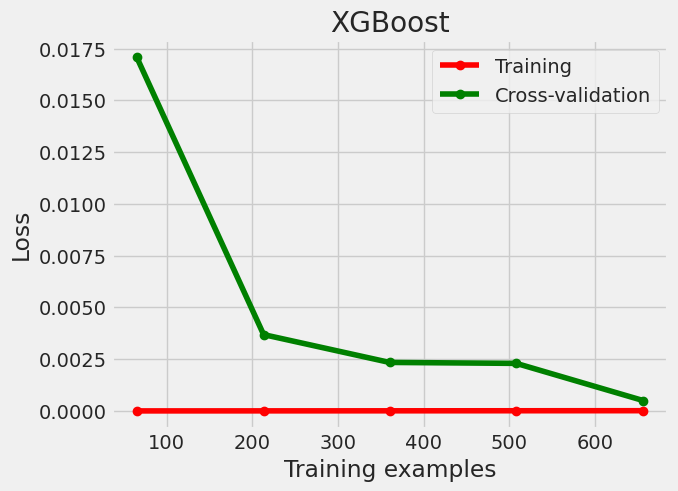

In [20]:
from sklearn.model_selection import learning_curve
train_sizes, train_loss, test_loss = learning_curve(
    model2, X, Y, cv=10, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(.1, 1.0, 5))
# loss值为负数，需要取反
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

# 设置样式与label
plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
         label="Training")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
        label="Cross-validation")

plt.title('XGBoost')
plt.xlabel("Training examples")
plt.ylabel("Loss")
# 显示图例
plt.legend(loc="best")
plt.show()